In [192]:
import shap

In [193]:
from tensorflow import keras

In [194]:
import os, re, sys
sys.path.append("/home/mimic/yesredpig/MIMIC-III_ICU_Readmission_Analysis-master/mimic3-readmission/")
os.environ["KERAS_BACKEND"]="tensorflow"
from mimic3models.common_keras_models import lstm_cnn
import pandas as pd
import pickle
import numpy as np
from keras.optimizers import Adam

In [195]:
from matplotlib import pyplot as plt

In [196]:
#%% Set hyper-parameters
l1 = 0
l2 = 0
dim = 16
depth = 2
epochs= 5
dropout = 0.3
batch_size = 8
timestep = 1.0
target_repl =0.0
rec_dropout = 0.0
target_repl_coef = 0.0
task = 'ihm'
prefix = ""
network = 'lstm_cnn'
loss = 'binary_crossentropy'
loss_weights = None

# Data Load

In [197]:
with open('./train_raw.pkl', 'rb') as f:
    train_raw = pickle.load(f)

In [198]:
with open('./val_raw.pkl', 'rb') as f:
    val_raw = pickle.load(f)

In [199]:
with open('./test_raw.pkl', 'rb') as f:
    test_raw = pickle.load(f)

In [200]:
X_train = train_raw[0]
y_train = train_raw[1]
X_val = val_raw[0]
y_val = val_raw[1]
X_test = val_raw[0]
y_test = val_raw[1]

In [201]:
print (X_train.shape, y_train.shape) 

(15264, 48, 390) (15264,)


In [202]:
print (X_val.shape, y_val.shape) 

(4850, 48, 390) (4850,)


In [203]:
print (X_test.shape, y_test.shape) 

(4850, 48, 390) (4850,)


In [204]:
(unique, counts) = np.unique(y_train, return_counts=True)
print(unique, counts)

[0 1] [7631 7633]


# 분리 

In [207]:
# 76개까지가 normalize_feature, 그 이후 300개가 ICD, 그이후 14개가 demorgraphic 

X_train_numeric = X_train[:, :,  0:76]
X_val_numeric = X_val[:, :,  0:76]
X_test_numeric = X_test[:, :,  0:76]

In [208]:
X_train_demographic = X_train[:, :,  376:391]
X_val_demographic = X_val[:, :,  376:391]
X_test_demographic = X_test[:, :,  376:391]

In [209]:
X_train_disease = X_train[:, :,  76:376]
X_val_disease = X_val[:, :,  76:376]
X_test_disease = X_test[:, :,  76:376]

In [210]:
len(X_train_numeric[0][0]) + len(X_train_demographic[0][0]) + len(X_train_disease[0][0])

390

# PCA
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [211]:
from sklearn.decomposition import PCA


In [213]:

pca = PCA(n_components=2)


In [233]:
# X_train_disease만 넣어서 PCA train 
# pca.fit (data.reshape(갯수, 48시간, 390)) # PCA 넣도록 SHAPE 3D-> 2D로 변경 (n개*48시간, 300차원)
pdf = pca.fit(X_train_disease.reshape(( X_train_disease.shape[0]* X_train_disease.shape[1], X_train_disease.shape[2])))



In [245]:
train_pca = pca.transform(X_train_disease.reshape(( X_train_disease.shape[0]*X_train_disease.shape[1], X_train_disease.shape[2])))
val_pca = pca.transform(X_val_disease.reshape(( X_val_disease.shape[0]*X_val_disease.shape[1],  X_val_disease.shape[2])))
test_pca= pca.transform(X_test_disease.reshape(( X_test_disease.shape[0]*X_test_disease.shape[1],  X_test_disease.shape[2])))

In [254]:
# pca 장축 선택 
X_train_pca = train_pca[:, 0]
X_val_pca = val_pca[:, 0]
X_test_pca = test_pca[:, 0]

In [255]:
# 1명당, 48row당, 1개 값으로 reshape
X_train_pca = X_train_pca.reshape(X_train_disease.shape[0],  X_train_disease.shape[1], 1)
X_val_pca = X_val_pca.reshape(X_val_disease.shape[0],  X_val_disease.shape[1], 1)
X_test_pca = X_test_pca.reshape(X_test_disease.shape[0],  X_test_disease.shape[1], 1)

# numeric, demographic feature와 concat 

In [267]:
# concat: numeric [0:76], demographic[76:90], icd[91] ->총 91dim 
X_train = np.concatenate([X_train_numeric, X_train_demographic, X_train_pca], -1)
X_val = np.concatenate([X_val_numeric, X_val_demographic,X_val_pca], -1)
X_test = np.concatenate([X_test_numeric, X_test_demographic, X_test_pca], -1)

# TOY Model

In [268]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional
from keras.layers import Input, Dense, LSTM, Dropout, Convolution1D, MaxPooling1D,Flatten, concatenate
from keras.callbacks import ModelCheckpoint, CSVLogger

In [269]:
def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
    outL = Dense(1, activation='relu')
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [272]:
# create model
model = createModel(16, 16, 16, 16, (X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, batch_size=8, epochs=30)

Epoch 1/30
15264/15264 [==============================] - 146s 10ms/step - loss: 0.2211
Epoch 2/30
15264/15264 [==============================] - 170s 11ms/step - loss: 0.2055
Epoch 3/30
15264/15264 [==============================] - 132s 9ms/step - loss: 0.2025
Epoch 4/30
15264/15264 [==============================] - 137s 9ms/step - loss: 0.1998
Epoch 5/30
15264/15264 [==============================] - 132s 9ms/step - loss: 0.1979
Epoch 6/30
15264/15264 [==============================] - 149s 10ms/step - loss: 0.1957
Epoch 7/30
15264/15264 [==============================] - 144s 9ms/step - loss: 0.1935
Epoch 8/30
15264/15264 [==============================] - 143s 9ms/step - loss: 0.1918
Epoch 9/30
15264/15264 [==============================] - 143s 9ms/step - loss: 0.1891
Epoch 10/30
15264/15264 [==============================] - 148s 10ms/step - loss: 0.1874
Epoch 11/30
15264/15264 [==============================] - 159s 10ms/step - loss: 0.1860
Epoch 12/30
15264/15264 [===========

In [273]:
model.save("my_model")


In [274]:
from mimic3models import metrics
import numpy as np 

predictions = model.predict(X_test, batch_size=1, verbose=1)
predictions = np.array(predictions)[:, 0]
metrics.print_metrics_binary(y_test, predictions)

4850/4850 [==============================] - 350s 72ms/step
confusion matrix:
[[2387 1513]
 [ 308  642]]
accuracy = 0.6245361
precision class 0 = 0.8857143
precision class 1 = 0.29791182
recall class 0 = 0.6120513
recall calss 1 = 0.6757895
AUC of ROC = 0.6912593792172739
AUC of PRC = 0.3329314940855691


{'acc': 0.6245361,
 'prec0': 0.8857143,
 'prec1': 0.29791182,
 'rec0': 0.6120513,
 'rec1': 0.6757895,
 'auroc': 0.6912593792172739,
 'auprc': 0.3329314940855691,
 'minpse': 0.3769309989701339}

# SHAP DeepExplainer
https://github.com/slundberg/shap
https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b

In [307]:
#https://www.kaggle.com/phamvanvung/shap-for-lstm
explainer = shap.DeepExplainer(model, X_train)


You have provided over 5k background samples! For better performance consider using smaller random sample.


In [309]:
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
a= X_test[0:50]
shap_values = explainer.shap_values(a)

In [317]:
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features=a[0])

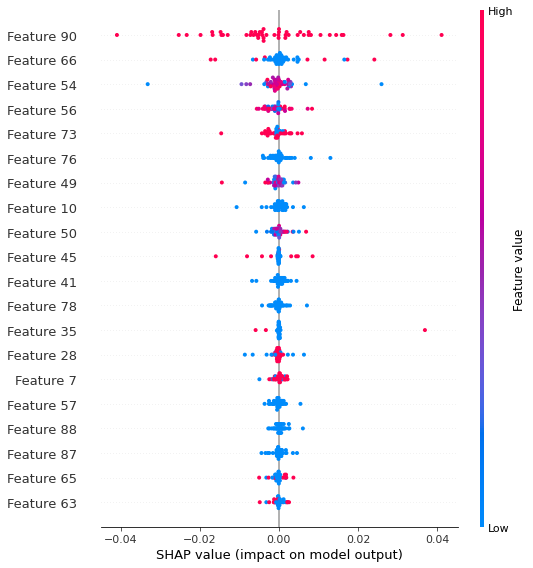

In [320]:
shap.summary_plot(shap_values[0][0], features=a[0])


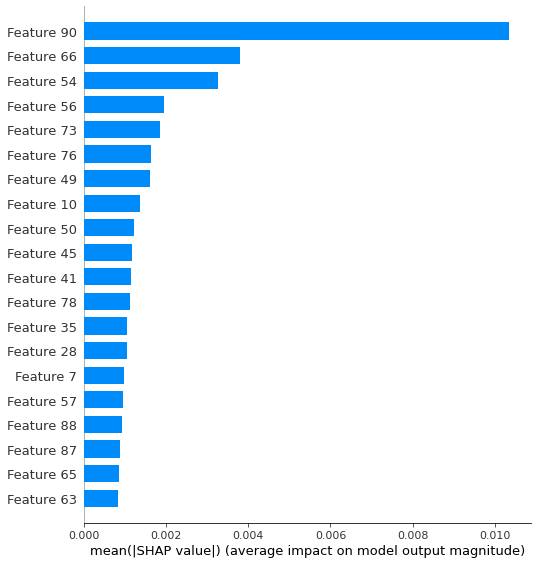

In [322]:
shap.summary_plot(shap_values[0][0], features=a[0], plot_type='bar')